In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time

%matplotlib inline

In [2]:
dcdf = pd.read_table('candidate_objects.dat', names=['field',
'candidate id',
'object id',
'object ra', 
'object dec', 
'object MJD', 
'object filter', 
'object magnitude', 
'object magnitude error', 
'object real/bogus score', 
'exposure id'], comment='#', delim_whitespace=True)

dcdf

,field,candidate id,object id,object ra,object dec,object MJD,object filter,object magnitude,object magnitude error,object real/bogus score,exposure id
0,COSMOS,DC21jyeo,1244336,148.627940,1.020521,59360.983202,g,21.359,0.084,0.956,1107
1,COSMOS,DC21jyeo,1244619,148.628248,1.020494,59360.984455,g,21.596,0.110,0.612,1108
2,COSMOS,DC21jvtr,1231065,148.394095,1.407216,59358.011504,g,18.943,0.009,1.000,1059
3,COSMOS,DC21jvtr,1232660,148.394358,1.407301,59358.012786,g,18.932,0.010,0.998,1060
4,COSMOS,DC21jvtr,1233917,148.394618,1.407363,59358.014054,r,18.440,0.005,1.000,1061
...,...,...,...,...,...,...,...,...,...,...,...
5663,ELAIS,DC21dreor,11448783,8.446305,-43.034973,59546.207082,g,22.297,0.073,0.924,5377
5664,ELAIS,DC22dvrhc,11563818,8.768651,-44.225484,59572.079390,g,22.786,0.083,0.967,5858
5665,ELAIS,DC22dvrhc,11572433,8.768626,-44.225219,59572.104555,g,22.809,0.090,0.682,5876
5666,ELAIS,DC22dvris,11563888,8.292958,-44.349343,59572.079390,g,22.893,0.096,0.598,5858


In [3]:
dcdf.head().to_csv('candidate_objects.csv')

In [4]:
dcdf.shape

(5668, 11)

In [5]:
dcdf.shape[0] == dcdf['object id'].unique().shape[0]

True

In [6]:
dcdf['field'].unique()

array(['COSMOS', 'ELAIS'], dtype=object)

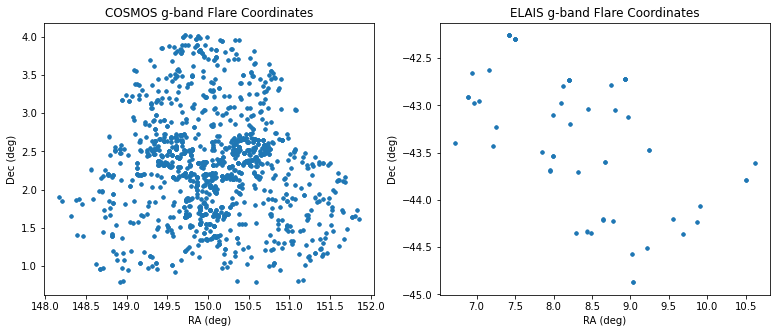

In [7]:
fig, ax = plt.subplots(1,2, figsize=(13,5))

ra1 = dcdf[(dcdf['field'] == 'COSMOS') & (dcdf['object filter'] == 'g')]['object ra']
dec1 = dcdf[(dcdf['field'] == 'COSMOS') & (dcdf['object filter'] == 'g')]['object dec']

ra2 = dcdf[(dcdf['field'] == 'ELAIS') & (dcdf['object filter'] == 'g')]['object ra']
dec2 = dcdf[(dcdf['field'] == 'ELAIS') & (dcdf['object filter'] == 'g')]['object dec']

ax[0].scatter(ra1, dec1, s=10)
ax[0].set_xlabel('RA (deg)')
ax[0].set_ylabel('Dec (deg)')
ax[0].set_title('COSMOS g-band Flare Coordinates');

ax[1].scatter(ra2, dec2, s=10)
ax[1].set_xlabel('RA (deg)')
ax[1].set_ylabel('Dec (deg)')
ax[1].set_title('ELAIS g-band Flare Coordinates');
plt.savefig('Figures/decam_coords.png', dpi=300, bbox_inches='tight')

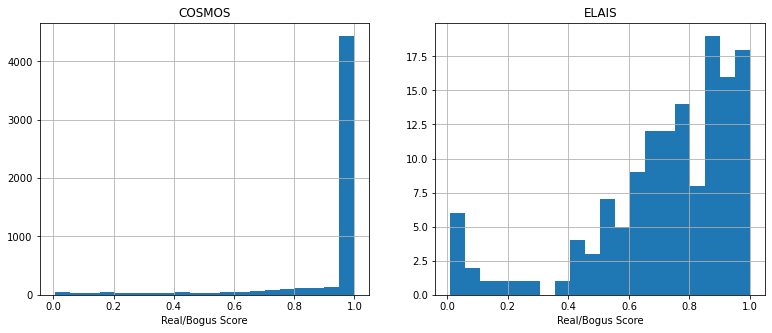

In [8]:
fig, ax = plt.subplots(1,2, figsize=(13,5))

dcdf[dcdf['field'] == 'COSMOS']['object real/bogus score'].hist(bins=20, ax=ax[0])
ax[0].set_xlabel('Real/Bogus Score')
ax[0].set_title('COSMOS')


dcdf[dcdf['field'] == 'ELAIS']['object real/bogus score'].hist(bins=20, ax=ax[1])
ax[1].set_xlabel('Real/Bogus Score')
ax[1].set_title('ELAIS')
plt.savefig('Figures/rbdist.png', dpi=300, bbox_inches='tight')

In [9]:
dcdf[dcdf['field'] == 'COSMOS']['object real/bogus score'].mean()

0.9215191751085384

In [10]:
dcdf[dcdf['field'] == 'ELAIS']['object real/bogus score'].mean()

0.7193357142857142

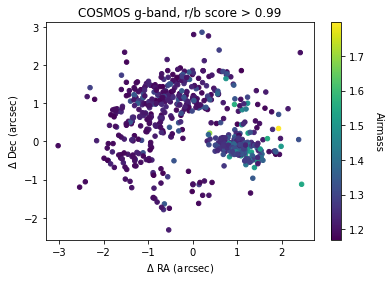

In [11]:
def dcoord(field, thr, filt):

        d_ra = np.zeros_like(dcdf[dcdf['field'] == field]['candidate id'].unique())
        d_dec = np.zeros_like(dcdf[dcdf['field'] == field]['candidate id'].unique())
        d_am = np.zeros_like(dcdf[dcdf['field'] == field]['candidate id'].unique())
        
        for i,id in enumerate(dcdf[dcdf['field'] == field]['candidate id'].unique()):
                #print('Candidate ID: {}'.format(id))

                subdf = dcdf[(dcdf['field'] == field) & (dcdf['object filter'] == filt) & 
                             (dcdf['object real/bogus score'] > thr) & (dcdf['candidate id'] == id)]

                if subdf.shape[0] > 1:

                        ra_i = subdf[subdf['object MJD'] == subdf['object MJD'].min()]['object ra'].values
                        dec_i = subdf[subdf['object MJD'] == subdf['object MJD'].min()]['object dec'].values
                        ra_f = subdf[subdf['object MJD'] == subdf['object MJD'].max()]['object ra'].values
                        dec_f = subdf[subdf['object MJD'] == subdf['object MJD'].max()]['object dec'].values

                        dra = ra_f - ra_i
                        ddec = dec_f - dec_i

                        if dra.size > 0:
                                d_ra[i] = dra[0]

                        if ddec.size > 0:
                                d_dec[i] = ddec[0]

                        mtn = EarthLocation.of_site('Cerro Tololo')
                        mjd = Time(subdf['object MJD'].values, format='mjd')
                        altaz = SkyCoord(ra = ra_i * u.degree, dec = dec_i*u.degree).transform_to(AltAz(obstime = mjd, location=mtn))
                        zd = 90 - altaz.alt.value
                        am_i = 1 / np.cos(np.deg2rad(zd))

                        mtn = EarthLocation.of_site('Cerro Tololo')
                        mjd = Time(subdf['object MJD'].values, format='mjd')
                        altaz = SkyCoord(ra = ra_f * u.degree, dec = dec_f*u.degree).transform_to(AltAz(obstime = mjd, location=mtn))
                        zd = 90 - altaz.alt.value
                        am_f = 1 / np.cos(np.deg2rad(zd))

                        d_am[i] = np.mean([am_f, am_i])

                else:
                        d_ra[i] = np.nan
                        d_dec[i] = np.nan
                        d_am[i] = np.nan

        fig = plt.figure()
        ax = plt.axes()
        s = ax.scatter(d_ra*3600, d_dec*3600, c=d_am, s=20)
        ax.set_xlabel(r'$\Delta$ RA (arcsec)')
        ax.set_ylabel(r'$\Delta$ Dec (arcsec)')
        ax.set_title('{0} {1}-band, r/b score > {2}'.format(field,filt,thr))
        cbar = fig.colorbar(s)
        cbar.set_label('Airmass', rotation=270, labelpad=20)
        fig.savefig('Figures/{0}_rb{1}_deltacoord.png'.format(field, thr), dpi=300, bbox_inches='tight')
        return ax

_ = dcoord('COSMOS', 0.99, 'g')

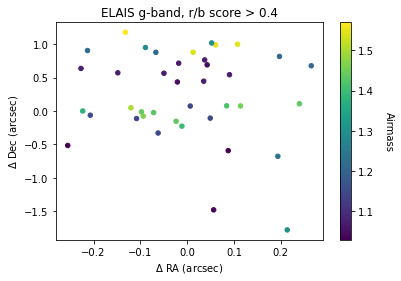

In [12]:
_ = dcoord('ELAIS', 0.4, 'g')

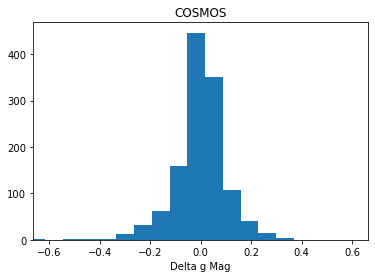

In [73]:
def dmag_hist(field, band, bins):

    h = []

    for i,id in enumerate(dcdf[dcdf['field'] == field]['candidate id'].unique()):

        subdf = dcdf[(dcdf['object filter'] == band) & (dcdf['candidate id'] == id)]

        if subdf.shape[0] > 1:
            
            h.append(subdf[subdf['object MJD'] == subdf['object MJD'].max()]['object magnitude'].values[0] - 
                    subdf[subdf['object MJD'] == subdf['object MJD'].min()]['object magnitude'].values[0])
    h = np.array(h)
    plt.hist(h, bins=bins);
    plt.xlim(-5*h.std(),5*h.std())
    plt.xlabel('Delta {} Mag'.format(band))
    plt.title(field)
    return h

h = dmag_hist('COSMOS', 'g', bins=50)


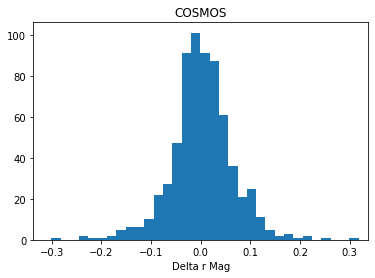

In [74]:
h = dmag_hist('COSMOS', 'r', bins=50)

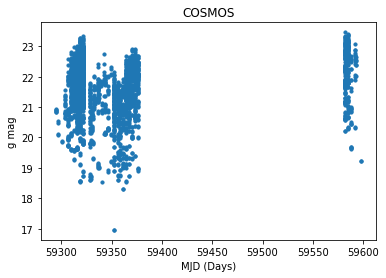

In [72]:
def dc_lcv(field, filt, log=False):  
    if log==True:
        plt.scatter(dcdf[(dcdf['field']==field) & (dcdf['object filter']==filt)]['object MJD'].values, 
                    dcdf[(dcdf['field']=='COSMOS') & (dcdf['object filter']=='g')]['object magnitude'].values, s=10)
        plt.ylabel('log {} mag'.format(filt))

    else:
        plt.scatter(dcdf[(dcdf['field']==field) & (dcdf['object filter']==filt)]['object MJD'].values, 
                    dcdf[(dcdf['field']=='COSMOS') & (dcdf['object filter']=='g')]['object magnitude'].values, s=10)
        plt.ylabel('{} mag'.format(filt))
   
    plt.xlabel('MJD (Days)')
    
    plt.title('{}'.format(field))

dc_lcv('COSMOS', 'g')